This file gives the MSE of SFC-HAE with different latent variables. The detailed information can be seen at each individual file in SFC_HAE ipynbs folder. In addition, this file only summarizes the MSE of SFC-HAE. For the MSE of 2SFC-HAE that the 2SFCs are generated respectively, please see the folder SFC_HAE ipynbs folder.



## Mounting your google drive

You can use google drive to store and access files e.g. storing and loading data from numpy or CSV files.  
Use the following command to mount your GDrive and access your files.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!pip install ffmpeg
!pip install vtk

  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=f5a6f3106fc4d3341eb8e335237f412ff808b56be8ae575257883385e5290a23
  Stored in directory: /root/.cache/pip/wheels/64/80/6e/caa3e16deb0267c3cbfd36862058a724144e19fdb9eb03af0f
Successfully built ffmpeg
     |████████████████████████████████| 59.5 MB 42 kB/s 
     |████████████████████████████████| 495 kB 60.3 MB/s 
     |████████████████████████████████| 3.1 MB 22.6 MB/s 
     |████████████████████████████████| 3.2 MB 59.0 MB/s 
     |████████████████████████████████| 74 kB 4.7 MB/s 
     |████████████████████████████████| 251 kB 68.1 MB/s 
     |████████████████████████████████| 1.3 MB 62.0 MB/s 
     |████████████████████████████████| 142 kB 71.0 MB/s 
     |████████████████████████████████| 294 kB 74.6 MB/s 


In [3]:
import os
# change the current path. The user can adjust the path depend on the requirement
os.chdir("/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF")
import vtktools

In [4]:
! /opt/bin/nvidia-smi

Sun Aug 22 03:26:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# !unzip csv_data.zip 

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import numpy.linalg as la
import scipy.linalg as sl
import scipy.sparse.linalg as spl
import matplotlib.pyplot as plt
import torch.nn as nn  # Neural network module
import scipy.sparse as sp
import scipy.optimize as sop
import progressbar
# making slopes
import torch
from torch.utils.data import TensorDataset
import torch.nn.functional as F
from matplotlib.pyplot import LinearLocator
import matplotlib as mpl
import matplotlib.colors as colors


# create an animation
from matplotlib import animation
from IPython.display import HTML

from matplotlib import animation
import math
import ffmpeg

!pip install pycm livelossplot
%pylab inline
from livelossplot import PlotLosses

from torch.utils.data import DataLoader
import torch.utils.data as Data

import time
import platform
print('python version', platform.python_version())
print('torch version', torch.__version__)
print('numpy version', np.version.version)

     |████████████████████████████████| 64 kB 2.3 MB/s 
     |████████████████████████████████| 571 kB 8.9 MB/s 
Populating the interactive namespace from numpy and matplotlib
python version 3.7.11
torch version 1.9.0+cu102
numpy version 1.19.5


In [7]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

device = 'cuda'  # Set out device to GPU

print('Cuda installed, running on GPU!')  # print sentence

Cuda installed, running on GPU!


In [8]:
# These functions are saved in function.py and the note are also added to that file
def saveIndex(path_train, path_valid, path_test,train_index, valid_index, test_index):    
    np.savetxt(path_train,train_index, delimiter=',')
    np.savetxt(path_valid,valid_index, delimiter=',')
    np.savetxt(path_test,test_index, delimiter=',')

def getIndex(path_train,path_valid,path_test):
    train_index = np.loadtxt(path_train,delimiter=",")
    valid_index = np.loadtxt(path_valid,delimiter=",")
    test_index = np.loadtxt(path_test,delimiter=",")
    return train_index,valid_index,test_index

def saveMode(path_train, path_valid, path_test,mode_train, mode_valid, mode_test):    
    np.savetxt(path_train,mode_train.cpu().data.numpy(), delimiter=',')
    np.savetxt(path_valid,mode_valid.cpu().data.numpy(), delimiter=',')
    np.savetxt(path_test,mode_test.cpu().data.numpy(), delimiter=',')

def getMode(path_train,path_valid,path_test):
    mode_train = np.loadtxt(path_train,delimiter=",")
    mode_valid = np.loadtxt(path_valid,delimiter=",")
    mode_test = np.loadtxt(path_test,delimiter=",")
    return mode_train,mode_valid,mode_test

def saveCsv(pathcsv,EPOCH):
    losses_combined = np.zeros((EPOCH,3))
    losses_combined[:,0] = np.asarray(epoch_list)
    losses_combined[:,1] = np.asarray(loss_list)
    losses_combined[:,2] = np.asarray(loss_valid)
    np.savetxt(pathcsv, losses_combined , delimiter=',')


def PlotMSELoss(pathName,name):
    data = np.loadtxt(pathName,delimiter=",")
    epoch = data[:,0]
    train_loss = data[:,1]
    val_loss = data[:,2]

    fig = plt.figure(figsize=(10,7))
    axe1 = plt.subplot(111)
    axe1.semilogy(epoch,train_loss,label = "train")
    axe1.plot(epoch,val_loss,label = "valid")
    axe1.legend(loc = "best",fontsize=14)
    axe1.set_xlabel("$epoch$",fontsize=14)
    axe1.set_ylabel("$MSE loss$",fontsize=14)
    axe1.set_title(name,fontsize=14)


def getTotal_decoded(training_decoded,valid_decoded,test_decoded,train_index,valid_index,test_index):
    total_decoded = np.zeros((nTotal,nNodes,2))
    for i in range(len(train_index)):
        total_decoded[int(train_index[i]),:,0] = training_decoded.cpu().detach().numpy()[i,:,0]
        total_decoded[int(train_index[i]),:,1] = training_decoded.cpu().detach().numpy()[i,:,1]

    for i in range(len(valid_index)):
        total_decoded[int(valid_index[i]),:,0] = valid_decoded.cpu().detach().numpy()[i,:,0]
        total_decoded[int(valid_index[i]),:,1] = valid_decoded.cpu().detach().numpy()[i,:,1]

    for i in range(len(test_index)):
        total_decoded[int(test_index[i]),:,0] = test_decoded.cpu().detach().numpy()[i,:,0]
        total_decoded[int(test_index[i]),:,1] = test_decoded.cpu().detach().numpy()[i,:,1]
    return total_decoded

def getMSELoss(pathName):
    epoch = pd.read_csv(pathName,usecols=[0]).values
    train_loss = pd.read_csv(pathName,usecols=[1]).values
    val_loss = pd.read_csv(pathName,usecols=[2]).values
    return train_loss,val_loss,epoch

# def get_clean_vtu(filename):
#     "Removes fields and arrays from a vtk file, leaving the coordinates/connectivity information."
#     vtu_data = vtktools.vtu(filename)
#     clean_vtu = vtktools.vtu()
#     clean_vtu.ugrid.DeepCopy(vtu_data.ugrid)
#     fieldNames = clean_vtu.GetFieldNames()
# # remove all fields and arrays from this vtu
#     for field in fieldNames:
#         clean_vtu.RemoveField(field)
#         fieldNames = clean_vtu.GetFieldNames()
#         vtkdata=clean_vtu.ugrid.GetCellData()
#         arrayNames = [vtkdata.GetArrayName(i) for i in range(vtkdata.GetNumberOfArrays())]
#     for array in arrayNames:
#         vtkdata.RemoveArray(array)
#     return clean_vtu

def index_split(train_ratio, valid_ratio, test_ratio, total_num):
    if train_ratio + valid_ratio + test_ratio != 1:
        raise ValueError("Three input ratio should sum to be 1!")
    total_index = np.arange(total_num)
    rng = np.random.default_rng()
    total_index = rng.permutation(total_index)
    knot_1 = int(total_num * train_ratio)
    knot_2 = int(total_num * valid_ratio) + knot_1
    train_index, valid_index, test_index = np.split(total_index, [knot_1, knot_2])
    return train_index, valid_index, test_index

In [9]:
path_train = "/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF/"+"new_FPC_train_index.csv"
path_valid = "/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF/"+"new_FPC_valid_index.csv"
path_test = "/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF/"+"new_FPC_test_index.csv"
# saveIndex(path_train, path_valid, path_test,train_index, valid_index, test_index)

In [10]:
# Load the train_index, valid_index and test_index
train_index,valid_index,test_index= getIndex(path_train,path_valid,path_test)
print(test_index)

[ 133.  490. 1480.  730.  481. 1382.  440.  750. 1502. 1451.  692. 1094.
 1679.  510. 1241. 1101.  543. 1312. 1432. 1988. 1148. 1801. 1519.  367.
 1858. 1043. 1175. 1218. 1479.  103. 1363.  800.  258. 1851.  267.  999.
  611. 1824.  318.  753. 1413.  727. 1273. 1358. 1090.  838.  250. 1763.
 1038.  439. 1199.  334. 1848. 1924. 1013.  271.  936.  600. 1553.  423.
 1467. 1658.  929. 1748.  783.  329.  303. 1067.  868.  374. 1102. 1843.
  683.  449.  855. 1142. 1393.  194. 1112.  636. 1617. 1910. 1722.  536.
 1149. 1765.  468. 1922. 1703. 1311.  341.  110. 1258. 1257. 1711.   93.
 1969.  396. 1259.  199.  962. 1704.  462. 1407.  634.  535. 1505.  537.
  612. 1707. 1565. 1963. 1955.    3. 1058. 1946.  372. 1653. 1077.  414.
  469.  680. 1430.  649.  215.  234. 1692.  653. 1455.  582. 1169. 1138.
  411.  518.  865. 1977. 1688.  822.  397. 1388. 1221.  239.  249. 1781.
 1751.  915.  278. 1970.  907.  477. 1552.  703.  870.  916. 1650.  561.
 1401.  129. 1123. 1804. 1871. 1527.  308.   94. 19

# load data

In [11]:
os.chdir('/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF')
print(os.getcwd())

# read in the data (1000 csv files)
nTrain = 1600
nValid = 200
nTest = 200
nTotal = nTrain + nValid + nTest
nNodes = 20550 # should really work this out


# The below method to load data is too slow. Therefore, we use load pt file

# [:, :, 2] is speed, [:, :, 3] is u, [:, :, 4] is v
# (speed not really needed)
# [:, :, 0] and [:, :, 1] are the SFC orderings

# training_data = np.zeros((nTrain,nNodes,5))
# for i in range(nTrain):
#     data = np.loadtxt('csv_data/data_' +str(int(train_index[i]))+ '.csv', delimiter=',')
#     training_data[i,:,:] = data
# training_data = np.array(training_data)
# print('size training data', training_data.shape)

# valid_data = np.zeros((nValid,nNodes,5))
# for i in range(nValid):
#     data = np.loadtxt('csv_data/data_' +str(int(valid_index[i]))+ '.csv', delimiter=',')
#     valid_data[i,:,:] = data
# valid_data = np.array(valid_data)
# print('size validation data', valid_data.shape)

# test_data = np.zeros((nTest,nNodes,5))
# for i in range(nTest):
#     data = np.loadtxt('csv_data/data_' +str(int(test_index[i]))+ '.csv', delimiter=',')
#     test_data[i,:,:] = data
# test_data = np.array(test_data)
# print('size test data', test_data.shape)

# total_data = np.zeros((nTotal,nNodes,5))
# for i in range(len(train_index)):
#     total_data[int(train_index[i]),:,:] = training_data[i,:,:]

# for i in range(len(valid_index)):
#     total_data[int(valid_index[i]),:,:] = valid_data[i,:,:]

# for i in range(len(test_index)):
#     total_data[int(test_index[i]),:,:] = test_data[i,:,:]
# print('size total data', total_data.shape)



/content/gdrive/MyDrive/Cola-Notebooks/FYP/YF


In [12]:
# Before we save the pt file, we must load the data according to the above method
# torch.save(training_data, '/content/gdrive/MyDrive/FPC_new_random_train.pt')
# torch.save(valid_data, '/content/gdrive/MyDrive/FPC_new_random_valid.pt')
# torch.save(test_data, '/content/gdrive/MyDrive/FPC_new_random_test.pt')
# torch.save(total_data, '/content/gdrive/MyDrive/FPC_new_random_total.pt')

In [13]:
# load the data, this method save the time
training_data = torch.load('/content/gdrive/MyDrive/FPC_new_random_train.pt')
valid_data = torch.load('/content/gdrive/MyDrive/FPC_new_random_valid.pt')
test_data = torch.load('/content/gdrive/MyDrive/FPC_new_random_test.pt')
total_data = torch.load('/content/gdrive/MyDrive/FPC_new_random_total.pt')
print(training_data.shape)
print(valid_data.shape)
print(test_data.shape)
print(total_data.shape)

(1600, 20550, 5)
(200, 20550, 5)
(200, 20550, 5)
(2000, 20550, 5)


In [14]:
# rescale the data so that u and v data lies in the range [-1,1] (and speed in [0,1])
ma = np.max(training_data[:, :, 2])
mi = np.min(training_data[:, :, 2])
k = 1./(ma - mi)
b = 1 - k*ma #k*mi
training_data[:, :, 2] = k * training_data[:, :, 2] + b #- b
# this won't be used

ma = np.max(training_data[:, :, 3])
mi = np.min(training_data[:, :, 3])
ku = 2./(ma - mi)
bu = 1 - ku*ma 
training_data[:, :, 3] = ku * training_data[:, :, 3] + bu
valid_data[:, :, 3] = ku * valid_data[:, :, 3] + bu
test_data[:, :, 3] = ku * test_data[:, :, 3] + bu
total_data[:, :, 3] = ku * total_data[:, :, 3] + bu

ma = np.max(training_data[:, :, 4])
mi = np.min(training_data[:, :, 4])
kv = 2./(ma - mi)
bv = 1 - kv*ma
training_data[:, :, 4] = kv * training_data[:, :, 4] + bv
valid_data[:, :, 4] = kv * valid_data[:, :, 4] + bv
test_data[:, :, 4] = kv * test_data[:, :, 4] + bv
total_data[:, :, 4] = kv * total_data[:, :, 4] + bv

# Hierarchical autoencoder

## Network architetcure

### First subnetwork

In [15]:
# Standard
class CNN_1(nn.Module):
    def __init__(self,hidden_1):
        super(CNN_1, self).__init__()
        self.encoder_h1 = nn.Sequential(
            # input shape (16,4,20550)  # The first 16 is the batch size
            nn.Tanh(),
            nn.Conv1d(4, 8, 16, 4, 9),
            # output shape (16, 8, 5139)
            nn.Tanh(),
            nn.Conv1d(8, 8, 16, 4, 9),
            # output shape (16, 8,1286)
            nn.Tanh(),
            nn.Conv1d(8, 16, 16, 4, 9),
            # output shape (16,16,323)
            nn.Tanh(),
            nn.Conv1d(16, 16,16, 4, 9),
            # output shape (16, 16, 82)
            nn.Tanh(),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(16*82, hidden_1),
            nn.Tanh(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_1, 16*82),
            nn.Tanh(),
        )
        self.decoder_h1 = nn.Sequential(
            # (b, 16, 81)
            nn.Tanh(),
            nn.ConvTranspose1d(16, 16, 17, 4, 9), # (16, 16, 323)
            nn.Tanh(),
            nn.ConvTranspose1d(16, 8, 16, 4, 9), # (16, 8, 1286)
            nn.Tanh(),
            nn.ConvTranspose1d(8, 8, 17, 4, 9), # (16, 8, 5139)
            nn.Tanh(),
            nn.ConvTranspose1d(8, 4, 16, 4, 9), # (16, 4, 20550)
            nn.Tanh(),
        )

        # input sparse layers, initialize weight as 0.33, bias as 0
        self.weight1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight1_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight1_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias1 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.weight11 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight11_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight11_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias11 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.weight2 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight2_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight2_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias2 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.weight22 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight22_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight22_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias22 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.weight3 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight3_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight3_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias3 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.zeros(k)),requires_grad = True)
        self.weight33 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight33_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight33_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias33 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.zeros(k)),requires_grad = True)
        self.weight4 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight4_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight4_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias4 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.zeros(k)),requires_grad = True)
        self.weight44 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight44_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight44_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias44 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.zeros(k)),requires_grad = True)
        
        # output sparse layers, initialize weight as 0.083, bias as 0
        self.weight_out1 = torch.nn.Parameter(torch.FloatTensor(0.083 *torch.ones(k)),requires_grad = True) 
        self.weight_out1_0 = torch.nn.Parameter(torch.FloatTensor(0.083* torch.ones(k)),requires_grad = True) 
        self.weight_out1_1 = torch.nn.Parameter(torch.FloatTensor(0.083* torch.ones(k)),requires_grad = True)
        
        self.weight_out11 = torch.nn.Parameter(torch.FloatTensor(0.083 *torch.ones(k)),requires_grad = True) 
        self.weight_out11_0 = torch.nn.Parameter(torch.FloatTensor(0.083* torch.ones(k)),requires_grad = True) 
        self.weight_out11_1 = torch.nn.Parameter(torch.FloatTensor(0.083* torch.ones(k)),requires_grad = True)
        
        self.weight_out2 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        self.weight_out2_0 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        self.weight_out2_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        
        self.weight_out22 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        self.weight_out22_0 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        self.weight_out22_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        
        self.weight_out3 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out3_0 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out3_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        
        self.weight_out33 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out33_0 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out33_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        
        self.weight_out4 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out4_0= torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out4_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        
        self.weight_out44 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out44_0= torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out44_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        
        self.bias_out1 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.bias_out2 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)


    def forward(self, x):
        # print("X_size",x.size())
        # first curve
        ToSFC1 = x[:, :, 0] # The first column is the first SFC ordering
        ToSFC1Up = torch.zeros_like(ToSFC1)
        ToSFC1Down = torch.zeros_like(ToSFC1)
        ToSFC1Up[:-1] = ToSFC1[1:]
        ToSFC1Up[-1] = ToSFC1[-1]
        ToSFC1Down[1:] = ToSFC1[:-1]
        ToSFC1Down[0] = ToSFC1[0]

        batch_num = ToSFC1.shape[0]
        #print("ToSFC1",ToSFC1.shape) # (16, 20550)
        x1 = x[:, :, 3:5] # The fourth column and fifth column are velocities u and v respectively
        #print("x1", x1.shape) #        # (16, 20550, 2)
        x1_1d = torch.zeros((batch_num, 4, k)).to(device)
        # first input sparse layer, then transform to sfc order1
        for j in range(batch_num):
            x1_1d[j, 0, :] = x1[j, :, 0][ToSFC1[j].long()] * self.weight1 + \
                             x1[j, :, 0][ToSFC1Up[j].long()] * self.weight1_0 + \
                             x1[j, :, 0][ToSFC1Down[j].long()] * self.weight1_1 + self.bias1
        
            x1_1d[j, 1, :] = x1[j, :, 0][ToSFC1[j].long()] * self.weight11 + \
                             x1[j, :, 0][ToSFC1Up[j].long()] * self.weight11_0 + \
                             x1[j, :, 0][ToSFC1Down[j].long()] * self.weight11_1 + self.bias11

            x1_1d[j, 2, :] = x1[j, :, 1][ToSFC1[j].long()] * self.weight2 + \
                             x1[j, :, 1][ToSFC1Up[j].long()] * self.weight2_0 + \
                             x1[j, :, 1][ToSFC1Down[j].long()] * self.weight2_1 + self.bias2

            x1_1d[j, 3, :] = x1[j, :, 1][ToSFC1[j].long()] * self.weight22 + \
                             x1[j, :, 1][ToSFC1Up[j].long()] * self.weight22_0 + \
                             x1[j, :, 1][ToSFC1Down[j].long()] * self.weight22_1 + self.bias22

        # first cnn encoder
        encoded_1 = self.encoder_h1(x1_1d.view(-1, 4, k)) #(16,4,20550)
        # print("encoded", encoded_1.shape)
        # flatten and concatenate
        encoded_3 = encoded_1.view(-1,16*82)
        # print("Before FC", encoded_3.shape)
        # fully connection
        encoded = self.fc1(encoded_3) # (b,64)
        # print("After encoder FC，the output of encoder",encoded.shape)  # [16,128]
        # 直接输出decoder
        decoded_3 = self.decoder_h1(self.fc2(encoded).view(-1, 16, 82))
        # print("The output of decoder: ", decoded_3.shape) # (16, 2, 20550)
        BackSFC1 = torch.argsort(ToSFC1)
        BackSFC1Up = torch.argsort(ToSFC1Up)
        BackSFC1Down = torch.argsort(ToSFC1Down)

        decoded_sp = torch.zeros((batch_num, k, 2)).to(device)
        # output sparse layer, resort according to sfc transform
        for j in range(batch_num):
            decoded_sp[j, :, 0] = decoded_3[j, 0, :][BackSFC1[j].long()]* self.weight_out1 + \
                                  decoded_3[j, 0, :][BackSFC1Up[j].long()] * self.weight_out1_0 + \
                                  decoded_3[j, 0, :][BackSFC1Down[j].long()] * self.weight_out1_1 + \
                                  decoded_3[j, 1, :][BackSFC1[j].long()]* self.weight_out11 + \
                                  decoded_3[j, 1, :][BackSFC1Up[j].long()] * self.weight_out11_0 + \
                                  decoded_3[j, 1, :][BackSFC1Down[j].long()] * self.weight_out11_1 + self.bias_out1

            decoded_sp[j, :, 1] = decoded_3[j, 2, :][BackSFC1[j].long()] * self.weight_out3 + \
                                  decoded_3[j, 2, :][BackSFC1Up[j].long()] * self.weight_out3_0 + \
                                  decoded_3[j, 2, :][BackSFC1Down[j].long()] * self.weight_out3_1 + \
                                  decoded_3[j, 3, :][BackSFC1[j].long()] * self.weight_out33 + \
                                  decoded_3[j, 3, :][BackSFC1Up[j].long()] * self.weight_out33_0 + \
                                  decoded_3[j, 3, :][BackSFC1Down[j].long()] * self.weight_out33_1 + self.bias_out2 
        
        # resort 1D to 2D
        decoded = F.tanh(decoded_sp) # both are BATCH_SIZE by nNodes by 2
        return encoded, decoded

### Second network

In [16]:
class CNN_2(nn.Module):
    def __init__(self,hidden_2):
        super(CNN_2, self).__init__()
        self.encoder_h1 = nn.Sequential(
            # input shape (16,4,20550)   # The first 16 is the batch size
            nn.Tanh(),
            nn.Conv1d(4, 16, 32, 4, 16),
            # output shape (16, 16, 5138)
            nn.Tanh(),
            nn.Conv1d(16, 16, 32, 4, 16),
            # output shape (16, 16,1285)
            nn.Tanh(),
            nn.Conv1d(16, 16, 32, 4, 16),
            # output shape (16,16,322)
            nn.Tanh(),
            nn.Conv1d(16, 16, 32, 4, 16),
            # output shape (16,16,81)
            nn.Tanh(),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(1296, hidden_2),
            nn.Tanh(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(2*hidden_2, 16*81),
            nn.Tanh(),
        )
        self.decoder_h1 = nn.Sequential(
            # (b, 16, 81)
            nn.Tanh(),
            nn.ConvTranspose1d(16, 16, 32, 4, 15), # (16, 16, 322)
            nn.Tanh(),
            nn.ConvTranspose1d(16, 16, 32, 4, 15), # (16, 16, 1286)
            nn.Tanh(),
            nn.ConvTranspose1d(16, 16, 32, 4, 16), # (16, 16, 5140)
            nn.Tanh(),
            nn.ConvTranspose1d(16, 4, 32, 4, 19), # (16, 4, 20550)
            nn.Tanh(),
        )

        # input sparse layers, initialize weight as 0.33, bias as 0
        self.weight1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight1_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight1_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias1 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.weight11 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight11_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight11_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias11 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.weight2 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight2_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight2_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias2 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.weight22 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight22_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight22_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias22 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.weight3 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight3_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight3_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias3 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.zeros(k)),requires_grad = True)
        self.weight33 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight33_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight33_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias33 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.zeros(k)),requires_grad = True)
        self.weight4 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight4_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight4_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias4 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.zeros(k)),requires_grad = True)
        self.weight44 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight44_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight44_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias44 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.zeros(k)),requires_grad = True)
        
        # output sparse layers, initialize weight as 0.083, bias as 0
        self.weight_out1 = torch.nn.Parameter(torch.FloatTensor(0.083 *torch.ones(k)),requires_grad = True) 
        self.weight_out1_0 = torch.nn.Parameter(torch.FloatTensor(0.083* torch.ones(k)),requires_grad = True) 
        self.weight_out1_1 = torch.nn.Parameter(torch.FloatTensor(0.083* torch.ones(k)),requires_grad = True)
        
        self.weight_out11 = torch.nn.Parameter(torch.FloatTensor(0.083 *torch.ones(k)),requires_grad = True) 
        self.weight_out11_0 = torch.nn.Parameter(torch.FloatTensor(0.083* torch.ones(k)),requires_grad = True) 
        self.weight_out11_1 = torch.nn.Parameter(torch.FloatTensor(0.083* torch.ones(k)),requires_grad = True)
        
        self.weight_out2 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        self.weight_out2_0 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        self.weight_out2_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        
        self.weight_out22 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        self.weight_out22_0 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        self.weight_out22_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        
        self.weight_out3 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out3_0 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out3_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        
        self.weight_out33 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out33_0 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out33_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        
        self.weight_out4 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out4_0= torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out4_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        
        self.weight_out44 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out44_0= torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out44_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        
        self.bias_out1 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.bias_out2 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)


    def forward(self, x, mode):
        # print("X_size",x.size())
        # first curve
        ToSFC1 = x[:, :, 0] # # The first column is the first SFC ordering
        ToSFC1Up = torch.zeros_like(ToSFC1)
        ToSFC1Down = torch.zeros_like(ToSFC1)
        ToSFC1Up[:-1] = ToSFC1[1:]
        ToSFC1Up[-1] = ToSFC1[-1]
        ToSFC1Down[1:] = ToSFC1[:-1]
        ToSFC1Down[0] = ToSFC1[0]

        batch_num = ToSFC1.shape[0]
        #print("ToSFC1",ToSFC1.shape) # (16, 20550)
        x1 = x[:, :, 3:5] # The fourth column and fifth column are velocities u and v respectively
        #print("x1", x1.shape) #        # (16, 20550, 2)
        x1_1d = torch.zeros((batch_num, 4, k)).to(device)
        # first input sparse layer, then transform to sfc order1
        for j in range(batch_num):
            x1_1d[j, 0, :] = x1[j, :, 0][ToSFC1[j].long()] * self.weight1 + \
                             x1[j, :, 0][ToSFC1Up[j].long()] * self.weight1_0 + \
                             x1[j, :, 0][ToSFC1Down[j].long()] * self.weight1_1 + self.bias1
        
            x1_1d[j, 1, :] = x1[j, :, 0][ToSFC1[j].long()] * self.weight11 + \
                             x1[j, :, 0][ToSFC1Up[j].long()] * self.weight11_0 + \
                             x1[j, :, 0][ToSFC1Down[j].long()] * self.weight11_1 + self.bias11

            x1_1d[j, 2, :] = x1[j, :, 1][ToSFC1[j].long()] * self.weight2 + \
                             x1[j, :, 1][ToSFC1Up[j].long()] * self.weight2_0 + \
                             x1[j, :, 1][ToSFC1Down[j].long()] * self.weight2_1 + self.bias2

            x1_1d[j, 3, :] = x1[j, :, 1][ToSFC1[j].long()] * self.weight22 + \
                             x1[j, :, 1][ToSFC1Up[j].long()] * self.weight22_0 + \
                             x1[j, :, 1][ToSFC1Down[j].long()] * self.weight22_1 + self.bias22

        # first cnn encoder
        encoded_1 = self.encoder_h1(x1_1d.view(-1, 4, k)) #(16,4,20550)
        # print("encoded", encoded_1.shape)
        # flatten and concatenate
        encoded_3 = encoded_1.view(-1,16*81)
        # print("Before FC", encoded_3.shape)
        # fully connection
        encoded = self.fc1(encoded_3) # (b,128)
        # print("After encoder FC，the output of encoder",encoded.shape)     
        encoded = torch.cat((encoded, mode),axis = 1)  # Combine the mode_1 to the x1
        
        # print("encoded_combine",encoded.shape)
        decoded_3 = self.decoder_h1(self.fc2(encoded).view(-1, 16, 81))
        # print("The output of decoder: ", decoded_3.shape) # (16, 2, 20550)
        BackSFC1 = torch.argsort(ToSFC1)
        BackSFC1Up = torch.argsort(ToSFC1Up)
        BackSFC1Down = torch.argsort(ToSFC1Down)

        # k = 20550
        # batch_num = ToSFC1.shape[0]
        decoded_sp = torch.zeros((batch_num, k, 2)).to(device)
        # output sparse layer, resort according to sfc transform
        for j in range(batch_num):
            decoded_sp[j, :, 0] = decoded_3[j, 0, :][BackSFC1[j].long()]* self.weight_out1 + \
                                  decoded_3[j, 0, :][BackSFC1Up[j].long()] * self.weight_out1_0 + \
                                  decoded_3[j, 0, :][BackSFC1Down[j].long()] * self.weight_out1_1 + \
                                  decoded_3[j, 1, :][BackSFC1[j].long()]* self.weight_out11 + \
                                  decoded_3[j, 1, :][BackSFC1Up[j].long()] * self.weight_out11_0 + \
                                  decoded_3[j, 1, :][BackSFC1Down[j].long()] * self.weight_out11_1 + self.bias_out1

            decoded_sp[j, :, 1] = decoded_3[j, 2, :][BackSFC1[j].long()] * self.weight_out3 + \
                                  decoded_3[j, 2, :][BackSFC1Up[j].long()] * self.weight_out3_0 + \
                                  decoded_3[j, 2, :][BackSFC1Down[j].long()] * self.weight_out3_1 + \
                                  decoded_3[j, 3, :][BackSFC1[j].long()] * self.weight_out33 + \
                                  decoded_3[j, 3, :][BackSFC1Up[j].long()] * self.weight_out33_0 + \
                                  decoded_3[j, 3, :][BackSFC1Down[j].long()] * self.weight_out33_1 + self.bias_out2       
        # resort 1D to 2D
        decoded = F.tanh(decoded_sp) # both are BATCH_SIZE by nNodes by 2
        return encoded, decoded

## Variable 4

### Save and Get mode

In [17]:
# SFC-CAE: one curve with nearest neighbour smoothing and compressing to 2 latent variables
print("compress to 2")
Latent_num = 2
torch.manual_seed(42)
# Hyper-parameters
EPOCH = 3001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_data.shape) # nTrain by number of nodes by 5

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_data, batch_size = BATCH_SIZE, shuffle = True)

compress to 2
(1600, 20550, 5)


In [18]:
# autoencoder = torch.load("./SFC_CAE/pkl/II_Eran3000_LV2_B16_n1600_L0.0001.pkl")

In [19]:
# # pass training, validation and test data through the autoencoder
# t_predict_0 = time.time()

# mode_1train, training_decoded = autoencoder.to(device)(torch.tensor(training_data).to(device))
# train_error_autoencoder = (training_decoded.cpu().detach().numpy() - training_data[:,:,3:5])
# print("MSE_err of training data", (train_error_autoencoder**2).mean())

# mode_1valid, valid_decoded = autoencoder.to(device)(torch.tensor(valid_data).to(device))
# valid_error_autoencoder = (valid_decoded.cpu().detach().numpy() - valid_data[:, :, 3:5])
# print("Mse_err of validation data", (valid_error_autoencoder**2).mean())

# mode_1test, test_decoded = autoencoder.to(device)(torch.tensor(test_data).to(device))
# test_error_autoencoder = (test_decoded.cpu().detach().numpy() - test_data[:, :, 3:5])
# print("Mse_err of test data", (test_error_autoencoder**2).mean())
# t_predict_1 = time.time()
# print("Rec:",t_predict_1-t_predict_0)

# total_decoded = getTotal_decoded(training_decoded,valid_decoded,test_decoded,train_index,valid_index,test_index)
# total_error_autoencoder = (total_decoded - total_data[:, :, 3:5])
# print("Mse_err of total data", (total_error_autoencoder**2).mean())

# print(mode_1train.shape)
# print(mode_1valid.shape)
# print(mode_1test.shape)

In [20]:
# Because we have saved the mode at SFC-CAE, we can directly load them
Latent_num = 2
torch.manual_seed(42)
BATCH_SIZE = 16
LR = 0.0001
nTrain = 1600

path_train = "./HAE/mode_new/II_mode1_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_train.csv"
path_valid = "./HAE/mode_new/II_mode1_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_valid.csv"
path_test = "./HAE/mode_new/II_mode1_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_test.csv"
print(path_train)
# saveMode(path_train,path_valid,path_test,mode_1train,mode_1valid,mode_1test)

./HAE/mode_new/II_mode1_LV2_Eran3000_B16_n1600_L0.0001_train.csv


In [21]:
mode_1train,mode_1valid,mode_1test = getMode(path_train,path_valid,path_test)
mode_1train = torch.from_numpy(mode_1train).to(device)
mode_1valid = torch.from_numpy(mode_1valid).to(device)
mode_1test = torch.from_numpy(mode_1test).to(device)
print(mode_1train.shape)
print(mode_1test.shape)
print(mode_1valid.shape)

torch.Size([1600, 2])
torch.Size([200, 2])
torch.Size([200, 2])


### Load model and calculate MSE

In [22]:
# SFC-HAE: one curve with nearest neighbour smoothing and compressing to 4 latent variables
print("compress to 4")
torch.manual_seed(42)
# Hyper-parameters
Latent_num = 4
EPOCH = 3001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_data.shape) # nTrain by number of nodes by 5

# Combing the input data and the mode
train_set = TensorDataset(torch.from_numpy(training_data), mode_1train)

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = train_set, batch_size =BATCH_SIZE , shuffle = True)

compress to 4
(1600, 20550, 5)


In [23]:
autoencoder_2 = torch.load("./HAE/pkl/II_I_Eran3000_LV4_B16_n1600_L0.0001.pkl")

In [24]:
# pass training, validation and test data through the autoencoder
t_predict_0 = time.time()
mode_2train, training_decoded_2 = autoencoder_2.to(device)(torch.tensor(training_data).to(device),mode_1train.float().to(device))
t_predict_1 = time.time()
train_error_autoencoder2 = (training_decoded_2.cpu().detach().numpy() - training_data[:,:,3:5])
print("MSE_err of training data", (train_error_autoencoder2**2).mean())

t_predict_2 = time.time()
mode_2valid, valid_decoded_2 = autoencoder_2.to(device)(torch.tensor(valid_data).to(device),mode_1valid.float().to(device))
t_predict_3 = time.time()
valid_error_autoencoder2 = (valid_decoded_2.cpu().detach().numpy() - valid_data[:, :, 3:5])
print("Mse_err of validation data", (valid_error_autoencoder2**2).mean())

t_predict_4 = time.time()
mode_2test, test_decoded_2 = autoencoder_2.to(device)(torch.tensor(test_data).to(device),mode_1test.float().to(device))
t_predict_5 = time.time()
test_error_autoencoder2 = (test_decoded_2.cpu().detach().numpy() - test_data[:, :, 3:5])
print("Mse_err of test data", (test_error_autoencoder2**2).mean())

# total_decoded2 = getTotal_decoded(training_decoded_2,valid_decoded_2,test_decoded_2,train_index,valid_index,test_index)
# total_error_autoencoder2 = (total_decoded2 - total_data[:, :, 3:5])
# print("Mse_err of total data", (total_error_autoencoder2**2).mean())

print(mode_2train.shape)
print(mode_2valid.shape)
print(mode_2test.shape)
print("Reconstruction time: ", t_predict_1 - t_predict_0+t_predict_3 - t_predict_2+t_predict_5 - t_predict_4)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE_err of training data 0.0007673355125279675
Mse_err of validation data 0.0007231584451279932
Mse_err of test data 0.0007136803894178418
torch.Size([1600, 4])
torch.Size([200, 4])
torch.Size([200, 4])
Reconstruction time:  5.321058511734009


### Plot loss

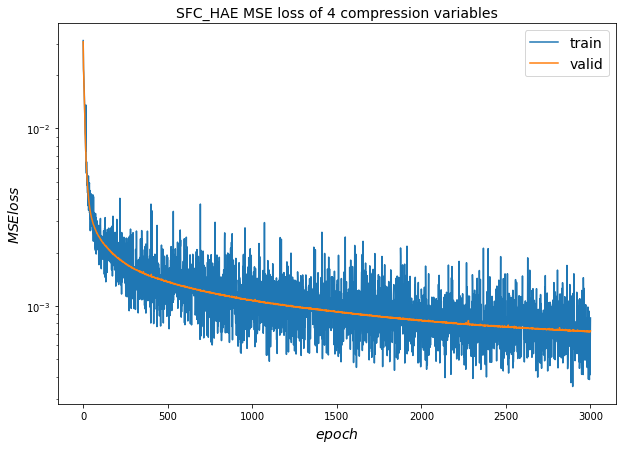

In [25]:
pathName = "./HAE/csv/II_I_Eran3000_LV4_B16_n1600_L0.0001.csv"
name = "SFC_HAE MSE loss of 4 compression variables"
PlotMSELoss(pathName,name)

## Variable 8

### Save and Get mode

In [17]:
# SFC-CAE: one curve with nearest neighbour smoothing and compressing to 4 latent variables
print("compress to 4")
Latent_num = 4
torch.manual_seed(42)
# Hyper-parameters
EPOCH = 3001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_data.shape) # nTrain by number of nodes by 5

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_data, batch_size = BATCH_SIZE, shuffle = True)

compress to 4
(1600, 20550, 5)


In [ ]:
# autoencoder = torch.load("./SFC_CAE/pkl/II_Eran3000_LV4_B16_n1600_L0.0001.pkl")

In [ ]:
# # pass training, validation and test data through the autoencoder
# t_predict_0 = time.time()

# mode_1train, training_decoded = autoencoder.to(device)(torch.tensor(training_data).to(device))
# train_error_autoencoder = (training_decoded.cpu().detach().numpy() - training_data[:,:,3:5])
# print("MSE_err of training data", (train_error_autoencoder**2).mean())

# mode_1valid, valid_decoded = autoencoder.to(device)(torch.tensor(valid_data).to(device))
# valid_error_autoencoder = (valid_decoded.cpu().detach().numpy() - valid_data[:, :, 3:5])
# print("Mse_err of validation data", (valid_error_autoencoder**2).mean())

# mode_1test, test_decoded = autoencoder.to(device)(torch.tensor(test_data).to(device))
# test_error_autoencoder = (test_decoded.cpu().detach().numpy() - test_data[:, :, 3:5])
# print("Mse_err of test data", (test_error_autoencoder**2).mean())
# t_predict_1 = time.time()
# print("Rec:",t_predict_1-t_predict_0)

# total_decoded = getTotal_decoded(training_decoded,valid_decoded,test_decoded,train_index,valid_index,test_index)
# total_error_autoencoder = (total_decoded - total_data[:, :, 3:5])
# print("Mse_err of total data", (total_error_autoencoder**2).mean())

# print(mode_1train.shape)
# print(mode_1valid.shape)
# print(mode_1test.shape)

In [18]:
# Because we have saved the mode at SFC-CAE, we can directly load them
Latent_num = 4
torch.manual_seed(42)
BATCH_SIZE = 16
LR = 0.0001
nTrain = 1600

path_train = "./HAE/mode_new/II_mode1_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_train.csv"
path_valid = "./HAE/mode_new/II_mode1_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_valid.csv"
path_test = "./HAE/mode_new/II_mode1_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_test.csv"
print(path_train)
# saveMode(path_train,path_valid,path_test,mode_1train,mode_1valid,mode_1test)

./HAE/mode_new/II_mode1_LV4_Eran3000_B16_n1600_L0.0001_train.csv


In [19]:
mode_1train,mode_1valid,mode_1test = getMode(path_train,path_valid,path_test)
mode_1train = torch.from_numpy(mode_1train).to(device)
mode_1valid = torch.from_numpy(mode_1valid).to(device)
mode_1test = torch.from_numpy(mode_1test).to(device)
print(mode_1train.shape)
print(mode_1test.shape)
print(mode_1valid.shape)

torch.Size([1600, 4])
torch.Size([200, 4])
torch.Size([200, 4])


### Load model and calculate MSE

In [20]:
# SFC-HAE: one curve with nearest neighbour smoothing and compressing to 8 latent variables
print("compress to 8")
torch.manual_seed(42)
# Hyper-parameters
Latent_num = 8
EPOCH = 2001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_data.shape) # nTrain by number of nodes by 5

# Combing the input data and the mode
train_set = TensorDataset(torch.from_numpy(training_data), mode_1train)

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = train_set, batch_size =BATCH_SIZE , shuffle = True)

compress to 8
(1600, 20550, 5)


In [21]:
autoencoder_2 = torch.load("./HAE/pkl/II_I_Eran2000_LV8_B16_n1600_L0.0001.pkl")

In [22]:
# pass training, validation and test data through the autoencoder
t_predict_0 = time.time()
mode_2train, training_decoded_2 = autoencoder_2.to(device)(torch.tensor(training_data).to(device),mode_1train.float().to(device))
t_predict_1 = time.time()
train_error_autoencoder2 = (training_decoded_2.cpu().detach().numpy() - training_data[:,:,3:5])
print("MSE_err of training data", (train_error_autoencoder2**2).mean())

t_predict_2 = time.time()
mode_2valid, valid_decoded_2 = autoencoder_2.to(device)(torch.tensor(valid_data).to(device),mode_1valid.float().to(device))
t_predict_3 = time.time()
valid_error_autoencoder2 = (valid_decoded_2.cpu().detach().numpy() - valid_data[:, :, 3:5])
print("Mse_err of validation data", (valid_error_autoencoder2**2).mean())

t_predict_4 = time.time()
mode_2test, test_decoded_2 = autoencoder_2.to(device)(torch.tensor(test_data).to(device),mode_1test.float().to(device))
t_predict_5 = time.time()
test_error_autoencoder2 = (test_decoded_2.cpu().detach().numpy() - test_data[:, :, 3:5])
print("Mse_err of test data", (test_error_autoencoder2**2).mean())

# total_decoded2 = getTotal_decoded(training_decoded_2,valid_decoded_2,test_decoded_2,train_index,valid_index,test_index)
# total_error_autoencoder2 = (total_decoded2 - total_data[:, :, 3:5])
# print("Mse_err of total data", (total_error_autoencoder2**2).mean())

print(mode_2train.shape)
print(mode_2valid.shape)
print(mode_2test.shape)
print("Reconstruction time: ", t_predict_1 - t_predict_0+t_predict_3 - t_predict_2+t_predict_5 - t_predict_4)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE_err of training data 0.000694944939773892
Mse_err of validation data 0.0006615920052828631
Mse_err of test data 0.0006487862188603596
torch.Size([1600, 8])
torch.Size([200, 8])
torch.Size([200, 8])
Reconstruction time:  5.979906797409058


### Plot loss

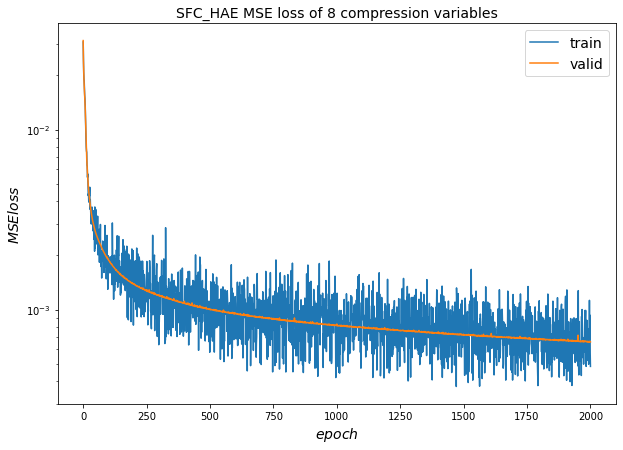

In [23]:
pathName = "./HAE/csv/II_I_Eran2000_LV8_B16_n1600_L0.0001.csv"
name = "SFC_HAE MSE loss of 8 compression variables"
PlotMSELoss(pathName,name)

## Variable 16

### Save and Get mode

In [17]:
# SFC-CAE: one curve with nearest neighbour smoothing and compressing to 8 latent variables
print("compress to 8")
Latent_num = 8
torch.manual_seed(42)
# Hyper-parameters
EPOCH = 2001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_data.shape) # nTrain by number of nodes by 5

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_data, batch_size = BATCH_SIZE, shuffle = True)

compress to 8
(1600, 20550, 5)


In [ ]:
# autoencoder = torch.load("./SFC_CAE/pkl/II_Eran2000_LV8_B16_n1600_L0.0001.pkl")

In [ ]:
# # pass training, validation and test data through the autoencoder
# t_predict_0 = time.time()

# mode_1train, training_decoded = autoencoder.to(device)(torch.tensor(training_data).to(device))
# train_error_autoencoder = (training_decoded.cpu().detach().numpy() - training_data[:,:,3:5])
# print("MSE_err of training data", (train_error_autoencoder**2).mean())

# mode_1valid, valid_decoded = autoencoder.to(device)(torch.tensor(valid_data).to(device))
# valid_error_autoencoder = (valid_decoded.cpu().detach().numpy() - valid_data[:, :, 3:5])
# print("Mse_err of validation data", (valid_error_autoencoder**2).mean())

# mode_1test, test_decoded = autoencoder.to(device)(torch.tensor(test_data).to(device))
# test_error_autoencoder = (test_decoded.cpu().detach().numpy() - test_data[:, :, 3:5])
# print("Mse_err of test data", (test_error_autoencoder**2).mean())
# t_predict_1 = time.time()

# # total_decoded = getTotal_decoded(training_decoded,valid_decoded,test_decoded,train_index,valid_index,test_index)
# # total_error_autoencoder = (total_decoded - total_data[:, :, 3:5])
# # print("Mse_err of total data", (total_error_autoencoder**2).mean())

# print(mode_1train.shape)
# print(mode_1valid.shape)
# print(mode_1test.shape)
# print("Reconstruction:",t_predict_1-t_predict_0)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE_err of training data 0.0007750525325503288
Mse_err of validation data 0.0007295926825350087
Mse_err of test data 0.0007196238005666296
torch.Size([1600, 8])
torch.Size([200, 8])
torch.Size([200, 8])
Reconstruction: 6.7046873569488525


In [18]:
# Because we have saved the mode at SFC-CAE, we can directly load them
Latent_num = 8
torch.manual_seed(42)
BATCH_SIZE = 16
LR = 0.0001
nTrain = 1600

path_train = "./HAE/mode_new/II_mode1_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_train.csv"
path_valid = "./HAE/mode_new/II_mode1_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_valid.csv"
path_test = "./HAE/mode_new/II_mode1_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_test.csv"
print(path_train)
# saveMode(path_train,path_valid,path_test,mode_1train,mode_1valid,mode_1test)

./HAE/mode_new/II_mode1_LV8_Eran2000_B16_n1600_L0.0001_train.csv


In [19]:
mode_1train,mode_1valid,mode_1test = getMode(path_train,path_valid,path_test)
mode_1train = torch.from_numpy(mode_1train).to(device)
mode_1valid = torch.from_numpy(mode_1valid).to(device)
mode_1test = torch.from_numpy(mode_1test).to(device)
print(mode_1train.shape)
print(mode_1test.shape)
print(mode_1valid.shape)

torch.Size([1600, 8])
torch.Size([200, 8])
torch.Size([200, 8])


### Load model and calculate MSE

In [20]:
# SFC-HAE: one curve with nearest neighbour smoothing and compressing to 16 latent variables
print("compress to 16")
torch.manual_seed(42)
# Hyper-parameters
Latent_num = 16
EPOCH = 2001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_data.shape) # nTrain by number of nodes by 5

# Combing the input data and the mode
train_set = TensorDataset(torch.from_numpy(training_data), mode_1train)

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = train_set, batch_size =BATCH_SIZE , shuffle = True)

compress to 16
(1600, 20550, 5)


In [21]:
autoencoder_2 = torch.load("./HAE/pkl/II_I_Eran2000_LV16_B16_n1600_L0.0001.pkl")

In [22]:
# pass training, validation and test data through the autoencoder
t_predict_0 = time.time()
mode_2train, training_decoded_2 = autoencoder_2.to(device)(torch.tensor(training_data).to(device),mode_1train.float().to(device))
t_predict_1 = time.time()
train_error_autoencoder2 = (training_decoded_2.cpu().detach().numpy() - training_data[:,:,3:5])
print("MSE_err of training data", (train_error_autoencoder2**2).mean())

t_predict_2 = time.time()
mode_2valid, valid_decoded_2 = autoencoder_2.to(device)(torch.tensor(valid_data).to(device),mode_1valid.float().to(device))
t_predict_3 = time.time()
valid_error_autoencoder2 = (valid_decoded_2.cpu().detach().numpy() - valid_data[:, :, 3:5])
print("Mse_err of validation data", (valid_error_autoencoder2**2).mean())

t_predict_4 = time.time()
mode_2test, test_decoded_2 = autoencoder_2.to(device)(torch.tensor(test_data).to(device),mode_1test.float().to(device))
t_predict_5 = time.time()
test_error_autoencoder2 = (test_decoded_2.cpu().detach().numpy() - test_data[:, :, 3:5])
print("Mse_err of test data", (test_error_autoencoder2**2).mean())

# total_decoded2 = getTotal_decoded(training_decoded_2,valid_decoded_2,test_decoded_2,train_index,valid_index,test_index)
# total_error_autoencoder2 = (total_decoded2 - total_data[:, :, 3:5])
# print("Mse_err of total data", (total_error_autoencoder2**2).mean())

print(mode_2train.shape)
print(mode_2valid.shape)
print(mode_2test.shape)
print("Reconstruction time: ", t_predict_1 - t_predict_0+t_predict_3 - t_predict_2+t_predict_5 - t_predict_4)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE_err of training data 0.00046142710936491587
Mse_err of validation data 0.0004432715144841416
Mse_err of test data 0.0004356465689053646
torch.Size([1600, 16])
torch.Size([200, 16])
torch.Size([200, 16])
Reconstruction time:  5.258707761764526


### Plot loss

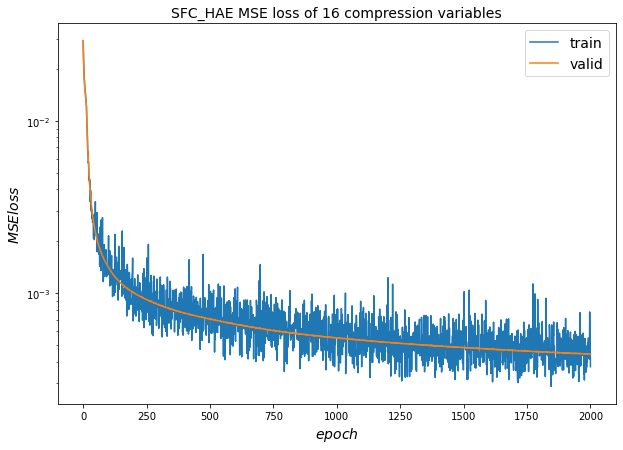

In [23]:
pathName = "./HAE/csv/II_I_Eran2000_LV16_B16_n1600_L0.0001.csv"
name = "SFC_HAE MSE loss of 16 compression variables"
PlotMSELoss(pathName,name)

## Variable 32

### Save and Get mode

In [17]:
# SFC-CAE: one curve with nearest neighbour smoothing and compressing to 16 latent variables
print("compress to 16")
Latent_num = 16
torch.manual_seed(42)
# Hyper-parameters
EPOCH = 2001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_data.shape) # nTrain by number of nodes by 5

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_data, batch_size = BATCH_SIZE, shuffle = True)

compress to 16
(1600, 20550, 5)


In [ ]:
# autoencoder = torch.load("./SFC_CAE/pkl/II_Eran2000_LV16_B16_n1600_L0.0001.pkl")

In [ ]:
# # pass training, validation and test data through the autoencoder
# t_predict_0 = time.time()

# mode_1train, training_decoded = autoencoder.to(device)(torch.tensor(training_data).to(device))
# train_error_autoencoder = (training_decoded.cpu().detach().numpy() - training_data[:,:,3:5])
# print("MSE_err of training data", (train_error_autoencoder**2).mean())

# mode_1valid, valid_decoded = autoencoder.to(device)(torch.tensor(valid_data).to(device))
# valid_error_autoencoder = (valid_decoded.cpu().detach().numpy() - valid_data[:, :, 3:5])
# print("Mse_err of validation data", (valid_error_autoencoder**2).mean())

# mode_1test, test_decoded = autoencoder.to(device)(torch.tensor(test_data).to(device))
# test_error_autoencoder = (test_decoded.cpu().detach().numpy() - test_data[:, :, 3:5])
# print("Mse_err of test data", (test_error_autoencoder**2).mean())
# t_predict_1 = time.time()


# # total_decoded = getTotal_decoded(training_decoded,valid_decoded,test_decoded,train_index,valid_index,test_index)
# # total_error_autoencoder = (total_decoded - total_data[:, :, 3:5])
# # print("Mse_err of total data", (total_error_autoencoder**2).mean())

# print(mode_1train.shape)
# print(mode_1valid.shape)
# print(mode_1test.shape)
# print("Rec:",t_predict_1-t_predict_0)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE_err of training data 0.0005865264993572022
Mse_err of validation data 0.0005631336189845338
Mse_err of test data 0.0005540129282371089
torch.Size([1600, 16])
torch.Size([200, 16])
torch.Size([200, 16])
Rec: 8.532732009887695


In [18]:
# Because we have saved the mode at SFC-CAE, we can directly load them
Latent_num = 16
torch.manual_seed(42)
BATCH_SIZE = 16
LR = 0.0001
nTrain = 1600

path_train = "./HAE/mode_new/II_mode1_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_train.csv"
path_valid = "./HAE/mode_new/II_mode1_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_valid.csv"
path_test = "./HAE/mode_new/II_mode1_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_test.csv"
print(path_train)
# saveMode(path_train,path_valid,path_test,mode_1train,mode_1valid,mode_1test)

./HAE/mode_new/II_mode1_LV16_Eran2000_B16_n1600_L0.0001_train.csv


In [19]:
mode_1train,mode_1valid,mode_1test = getMode(path_train,path_valid,path_test)
mode_1train = torch.from_numpy(mode_1train).to(device)
mode_1valid = torch.from_numpy(mode_1valid).to(device)
mode_1test = torch.from_numpy(mode_1test).to(device)
print(mode_1train.shape)
print(mode_1test.shape)
print(mode_1valid.shape)

torch.Size([1600, 16])
torch.Size([200, 16])
torch.Size([200, 16])


### Load model and calculate MSE

In [20]:
# SFC-HAE: one curve with nearest neighbour smoothing and compressing to 32 latent variables
print("compress to 32")
torch.manual_seed(42)
# Hyper-parameters
Latent_num = 32
EPOCH = 2001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_data.shape) # nTrain by number of nodes by 5

# Combing the input data and the mode
train_set = TensorDataset(torch.from_numpy(training_data), mode_1train)

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = train_set, batch_size =BATCH_SIZE , shuffle = True)

compress to 32
(1600, 20550, 5)


In [21]:
autoencoder_2 = torch.load("./HAE/pkl/II_I_Eran2000_LV32_B16_n1600_L0.0001.pkl")

In [22]:
# pass training, validation and test data through the autoencoder
t_predict_0 = time.time()
mode_2train, training_decoded_2 = autoencoder_2.to(device)(torch.tensor(training_data).to(device),mode_1train.float().to(device))
t_predict_1 = time.time()
train_error_autoencoder2 = (training_decoded_2.cpu().detach().numpy() - training_data[:,:,3:5])
print("MSE_err of training data", (train_error_autoencoder2**2).mean())

t_predict_2 = time.time()
mode_2valid, valid_decoded_2 = autoencoder_2.to(device)(torch.tensor(valid_data).to(device),mode_1valid.float().to(device))
t_predict_3 = time.time()
valid_error_autoencoder2 = (valid_decoded_2.cpu().detach().numpy() - valid_data[:, :, 3:5])
print("Mse_err of validation data", (valid_error_autoencoder2**2).mean())

t_predict_4 = time.time()
mode_2test, test_decoded_2 = autoencoder_2.to(device)(torch.tensor(test_data).to(device),mode_1test.float().to(device))
t_predict_5 = time.time()
test_error_autoencoder2 = (test_decoded_2.cpu().detach().numpy() - test_data[:, :, 3:5])
print("Mse_err of test data", (test_error_autoencoder2**2).mean())

# total_decoded2 = getTotal_decoded(training_decoded_2,valid_decoded_2,test_decoded_2,train_index,valid_index,test_index)
# total_error_autoencoder2 = (total_decoded2 - total_data[:, :, 3:5])
# print("Mse_err of total data", (total_error_autoencoder2**2).mean())

print(mode_2train.shape)
print(mode_2valid.shape)
print(mode_2test.shape)
print("Reconstruction time: ", t_predict_1 - t_predict_0+t_predict_3 - t_predict_2+t_predict_5 - t_predict_4)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE_err of training data 0.0003604982514911223
Mse_err of validation data 0.0003528250058531332
Mse_err of test data 0.00034436836188879845
torch.Size([1600, 32])
torch.Size([200, 32])
torch.Size([200, 32])
Reconstruction time:  7.39333176612854


### Plot loss

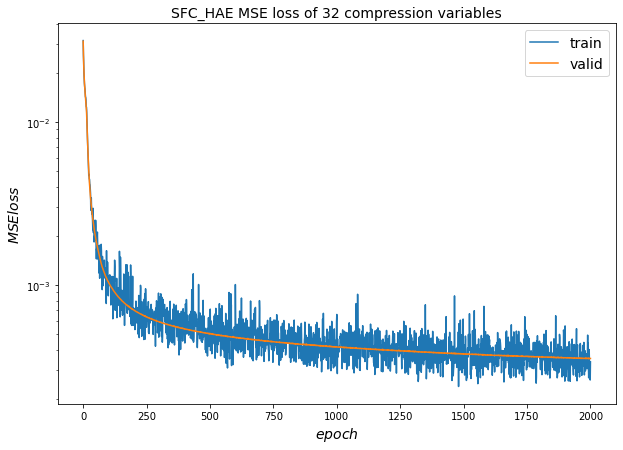

In [23]:
pathName = "./HAE/csv/II_I_Eran2000_LV32_B16_n1600_L0.0001.csv"
name = "SFC_HAE MSE loss of 32 compression variables"
PlotMSELoss(pathName,name)

## Variable 64

### Save and Get mode

In [ ]:
# SFC-CAE: one curve with nearest neighbour smoothing and compressing to 32 latent variables
print("compress to 32")
Latent_num = 32
torch.manual_seed(42)
# Hyper-parameters
EPOCH = 2001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_data.shape) # nTrain by number of nodes by 5

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_data, batch_size = BATCH_SIZE, shuffle = True)

compress to 32
(1600, 20550, 5)


In [ ]:
# autoencoder = torch.load("./SFC_CAE/pkl/II_Eran2000_LV32_B16_n1600_L0.0001.pkl")

In [ ]:
# # pass training, validation and test data through the autoencoder
# t_predict_0 = time.time()

# mode_1train, training_decoded = autoencoder.to(device)(torch.tensor(training_data).to(device))
# train_error_autoencoder = (training_decoded.cpu().detach().numpy() - training_data[:,:,3:5])
# print("MSE_err of training data", (train_error_autoencoder**2).mean())

# mode_1valid, valid_decoded = autoencoder.to(device)(torch.tensor(valid_data).to(device))
# valid_error_autoencoder = (valid_decoded.cpu().detach().numpy() - valid_data[:, :, 3:5])
# print("Mse_err of validation data", (valid_error_autoencoder**2).mean())

# mode_1test, test_decoded = autoencoder.to(device)(torch.tensor(test_data).to(device))
# test_error_autoencoder = (test_decoded.cpu().detach().numpy() - test_data[:, :, 3:5])
# print("Mse_err of test data", (test_error_autoencoder**2).mean())
# t_predict_1 = time.time()


# # total_decoded = getTotal_decoded(training_decoded,valid_decoded,test_decoded,train_index,valid_index,test_index)
# # total_error_autoencoder = (total_decoded - total_data[:, :, 3:5])
# # print("Mse_err of total data", (total_error_autoencoder**2).mean())

# print(mode_1train.shape)
# print(mode_1valid.shape)
# print(mode_1test.shape)
# print("Rec:",t_predict_1-t_predict_0)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE_err of training data 0.00043976261054683033
Mse_err of validation data 0.0004301108939292128
Mse_err of test data 0.00042198910145304307
torch.Size([1600, 32])
torch.Size([200, 32])
torch.Size([200, 32])
Rec: 6.052201271057129


In [ ]:
# Because we have saved the mode at SFC-CAE, we can directly load them
Latent_num = 32
torch.manual_seed(42)
BATCH_SIZE = 16
LR = 0.0001
nTrain = 1600

path_train = "./HAE/mode_new/II_mode1_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_train.csv"
path_valid = "./HAE/mode_new/II_mode1_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_valid.csv"
path_test = "./HAE/mode_new/II_mode1_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_test.csv"
print(path_train)
# saveMode(path_train,path_valid,path_test,mode_1train,mode_1valid,mode_1test)

./HAE/mode_new/II_mode1_LV32_Eran2000_B16_n1600_L0.0001_train.csv


In [ ]:
mode_1train,mode_1valid,mode_1test = getMode(path_train,path_valid,path_test)
mode_1train = torch.from_numpy(mode_1train).to(device)
mode_1valid = torch.from_numpy(mode_1valid).to(device)
mode_1test = torch.from_numpy(mode_1test).to(device)
print(mode_1train.shape)
print(mode_1test.shape)
print(mode_1valid.shape)

torch.Size([1600, 32])
torch.Size([200, 32])
torch.Size([200, 32])


### Load model and calculate MSE

In [ ]:
# SFC-HAE: one curve with nearest neighbour smoothing and compressing to 64 latent variables
print("compress to 64")
torch.manual_seed(42)
# Hyper-parameters
Latent_num = 64
EPOCH = 2001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_data.shape) # nTrain by number of nodes by 5

# Combing the input data and the mode
train_set = TensorDataset(torch.from_numpy(training_data), mode_1train)

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = train_set, batch_size =BATCH_SIZE , shuffle = True)

compress to 64
(1600, 20550, 5)


In [ ]:
autoencoder_2 = torch.load("./HAE/pkl/II_I_Eran2000_LV64_B16_n1600_L0.0001.pkl")

In [ ]:
# pass training, validation and test data through the autoencoder
t_predict_0 = time.time()
mode_2train, training_decoded_2 = autoencoder_2.to(device)(torch.tensor(training_data).to(device),mode_1train.float().to(device))
t_predict_1 = time.time()
train_error_autoencoder2 = (training_decoded_2.cpu().detach().numpy() - training_data[:,:,3:5])
print("MSE_err of training data", (train_error_autoencoder2**2).mean())

t_predict_2 = time.time()
mode_2valid, valid_decoded_2 = autoencoder_2.to(device)(torch.tensor(valid_data).to(device),mode_1valid.float().to(device))
t_predict_3 = time.time()
valid_error_autoencoder2 = (valid_decoded_2.cpu().detach().numpy() - valid_data[:, :, 3:5])
print("Mse_err of validation data", (valid_error_autoencoder2**2).mean())

t_predict_4 = time.time()
mode_2test, test_decoded_2 = autoencoder_2.to(device)(torch.tensor(test_data).to(device),mode_1test.float().to(device))
t_predict_5 = time.time()
test_error_autoencoder2 = (test_decoded_2.cpu().detach().numpy() - test_data[:, :, 3:5])
print("Mse_err of test data", (test_error_autoencoder2**2).mean())

# total_decoded2 = getTotal_decoded(training_decoded_2,valid_decoded_2,test_decoded_2,train_index,valid_index,test_index)
# total_error_autoencoder2 = (total_decoded2 - total_data[:, :, 3:5])
# print("Mse_err of total data", (total_error_autoencoder2**2).mean())

print(mode_2train.shape)
print(mode_2valid.shape)
print(mode_2test.shape)
print("Reconstruction time: ", t_predict_1 - t_predict_0+t_predict_3 - t_predict_2+t_predict_5 - t_predict_4)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE_err of training data 0.00027091932318453865
Mse_err of validation data 0.0002651228152677472
Mse_err of test data 0.0002596183391482971
torch.Size([1600, 64])
torch.Size([200, 64])
torch.Size([200, 64])
Reconstruction time:  6.429408550262451


### Plot loss

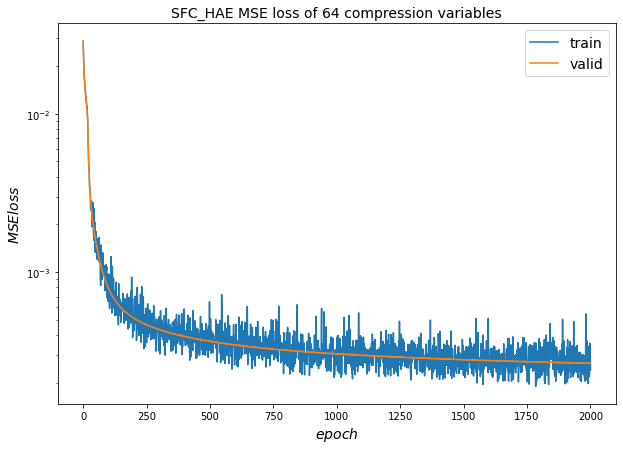

In [24]:
pathName = "./HAE/csv/II_I_Eran2000_LV64_B16_n1600_L0.0001.csv"
name = "SFC_HAE MSE loss of 64 compression variables"
PlotMSELoss(pathName,name)

## Variable 128

### Save and Get mode

In [ ]:
# SFC-CAE: one curve with nearest neighbour smoothing and compressing to 64 latent variables
print("compress to 64")
Latent_num = 64
torch.manual_seed(42)
# Hyper-parameters
EPOCH = 2001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_data.shape) # nTrain by number of nodes by 5

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_data, batch_size = BATCH_SIZE, shuffle = True)

compress to 64
(1600, 20550, 5)


In [ ]:
# autoencoder = torch.load("./SFC_CAE/pkl/II_Eran2000_LV64_B16_n1600_L0.0001.pkl")

In [ ]:
# # pass training, validation and test data through the autoencoder
# t_predict_0 = time.time()

# mode_1train, training_decoded = autoencoder.to(device)(torch.tensor(training_data).to(device))
# train_error_autoencoder = (training_decoded.cpu().detach().numpy() - training_data[:,:,3:5])
# print("MSE_err of training data", (train_error_autoencoder**2).mean())

# mode_1valid, valid_decoded = autoencoder.to(device)(torch.tensor(valid_data).to(device))
# valid_error_autoencoder = (valid_decoded.cpu().detach().numpy() - valid_data[:, :, 3:5])
# print("Mse_err of validation data", (valid_error_autoencoder**2).mean())

# mode_1test, test_decoded = autoencoder.to(device)(torch.tensor(test_data).to(device))
# test_error_autoencoder = (test_decoded.cpu().detach().numpy() - test_data[:, :, 3:5])
# print("Mse_err of test data", (test_error_autoencoder**2).mean())
# t_predict_1 = time.time()


# # total_decoded = getTotal_decoded(training_decoded,valid_decoded,test_decoded,train_index,valid_index,test_index)
# # total_error_autoencoder = (total_decoded - total_data[:, :, 3:5])
# # print("Mse_err of total data", (total_error_autoencoder**2).mean())

# print(mode_1train.shape)
# print(mode_1valid.shape)
# print(mode_1test.shape)
# print("Rec:",t_predict_1-t_predict_0)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE_err of training data 0.00033798539252582365
Mse_err of validation data 0.0003331408006407273
Mse_err of test data 0.0003247558797465547
torch.Size([1600, 64])
torch.Size([200, 64])
torch.Size([200, 64])
Rec: 6.347157716751099


In [ ]:
# Because we have saved the mode at SFC-CAE, we can directly load them
Latent_num = 64
torch.manual_seed(42)
BATCH_SIZE = 16
LR = 0.0001
nTrain = 1600

path_train = "./HAE/mode_new/II_mode1_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_train.csv"
path_valid = "./HAE/mode_new/II_mode1_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_valid.csv"
path_test = "./HAE/mode_new/II_mode1_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_test.csv"
print(path_train)
# saveMode(path_train,path_valid,path_test,mode_1train,mode_1valid,mode_1test)


./HAE/mode_new/II_mode1_LV64_Eran2000_B16_n1600_L0.0001_train.csv


In [ ]:
mode_1train,mode_1valid,mode_1test = getMode(path_train,path_valid,path_test)
mode_1train = torch.from_numpy(mode_1train).to(device)
mode_1valid = torch.from_numpy(mode_1valid).to(device)
mode_1test = torch.from_numpy(mode_1test).to(device)
print(mode_1train.shape)
print(mode_1test.shape)
print(mode_1valid.shape)

torch.Size([1600, 64])
torch.Size([200, 64])
torch.Size([200, 64])


### Load model and calculate MSE

In [ ]:
# SFC-HAE: one curve with nearest neighbour smoothing and compressing to 128 latent variables
print("compress to 128")
torch.manual_seed(42)
# Hyper-parameters
Latent_num = 128
EPOCH = 2001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_data.shape) # nTrain by number of nodes by 5

# Combing the input data and the mode
train_set = TensorDataset(torch.from_numpy(training_data), mode_1train)

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = train_set, batch_size =BATCH_SIZE , shuffle = True)

compress to 128
(1600, 20550, 5)


In [ ]:
autoencoder_2 = torch.load("./HAE/pkl/II_I_Eran2000_LV128_B16_n1600_L0.0001.pkl")

In [ ]:
# pass training, validation and test data through the autoencoder
t_predict_0 = time.time()
mode_2train, training_decoded_2 = autoencoder_2.to(device)(torch.tensor(training_data).to(device),mode_1train.float().to(device))
t_predict_1 = time.time()
train_error_autoencoder2 = (training_decoded_2.cpu().detach().numpy() - training_data[:,:,3:5])
print("MSE_err of training data", (train_error_autoencoder2**2).mean())

t_predict_2 = time.time()
mode_2valid, valid_decoded_2 = autoencoder_2.to(device)(torch.tensor(valid_data).to(device),mode_1valid.float().to(device))
t_predict_3 = time.time()
valid_error_autoencoder2 = (valid_decoded_2.cpu().detach().numpy() - valid_data[:, :, 3:5])
print("Mse_err of validation data", (valid_error_autoencoder2**2).mean())

t_predict_4 = time.time()
mode_2test, test_decoded_2 = autoencoder_2.to(device)(torch.tensor(test_data).to(device),mode_1test.float().to(device))
t_predict_5 = time.time()
test_error_autoencoder2 = (test_decoded_2.cpu().detach().numpy() - test_data[:, :, 3:5])
print("Mse_err of test data", (test_error_autoencoder2**2).mean())

# total_decoded2 = getTotal_decoded(training_decoded_2,valid_decoded_2,test_decoded_2,train_index,valid_index,test_index)
# total_error_autoencoder2 = (total_decoded2 - total_data[:, :, 3:5])
# print("Mse_err of total data", (total_error_autoencoder2**2).mean())

print(mode_2train.shape)
print(mode_2valid.shape)
print(mode_2test.shape)
print("Reconstruction time: ", t_predict_1 - t_predict_0+t_predict_3 - t_predict_2+t_predict_5 - t_predict_4)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE_err of training data 0.00023320918013227537
Mse_err of validation data 0.0002268004305583024
Mse_err of test data 0.00022178317602285558
torch.Size([1600, 128])
torch.Size([200, 128])
torch.Size([200, 128])
Reconstruction time:  6.317685842514038


### Plot loss

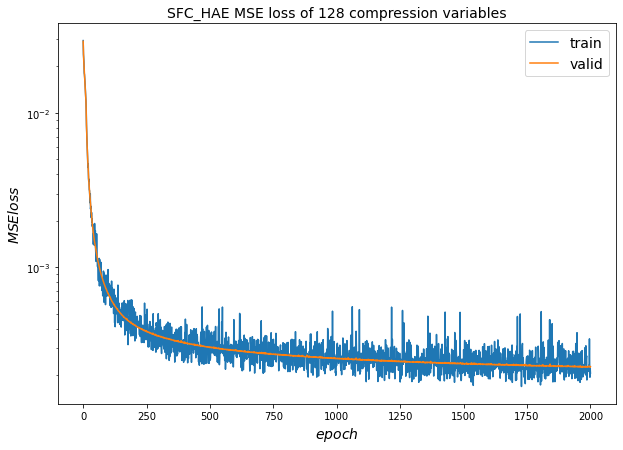

In [25]:
pathName = "./HAE/csv/II_I_Eran2000_LV128_B16_n1600_L0.0001.csv"
name = "SFC_HAE MSE loss of 128 compression variables"
PlotMSELoss(pathName,name)

## Variable 256

### Save and Get mode

In [ ]:
# SFC-CAE: one curve with nearest neighbour smoothing and compressing to 128 latent variables
print("compress to 128")
Latent_num = 128
torch.manual_seed(42)
# Hyper-parameters
EPOCH = 2001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_data.shape) # nTrain by number of nodes by 5

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_data, batch_size = BATCH_SIZE, shuffle = True)

compress to 128
(1600, 20550, 5)


In [ ]:
# autoencoder = torch.load("./SFC_CAE/pkl/II_Eran2000_LV128_B16_n1600_L0.0001.pkl")

In [ ]:
# # pass training, validation and test data through the autoencoder
# t_predict_0 = time.time()

# mode_1train, training_decoded = autoencoder.to(device)(torch.tensor(training_data).to(device))
# train_error_autoencoder = (training_decoded.cpu().detach().numpy() - training_data[:,:,3:5])
# print("MSE_err of training data", (train_error_autoencoder**2).mean())

# mode_1valid, valid_decoded = autoencoder.to(device)(torch.tensor(valid_data).to(device))
# valid_error_autoencoder = (valid_decoded.cpu().detach().numpy() - valid_data[:, :, 3:5])
# print("Mse_err of validation data", (valid_error_autoencoder**2).mean())

# mode_1test, test_decoded = autoencoder.to(device)(torch.tensor(test_data).to(device))
# test_error_autoencoder = (test_decoded.cpu().detach().numpy() - test_data[:, :, 3:5])
# print("Mse_err of test data", (test_error_autoencoder**2).mean())
# t_predict_1 = time.time()

# total_decoded = getTotal_decoded(training_decoded,valid_decoded,test_decoded,train_index,valid_index,test_index)
# total_error_autoencoder = (total_decoded - total_data[:, :, 3:5])
# print("Mse_err of total data", (total_error_autoencoder**2).mean())

# print(mode_1train.shape)
# print(mode_1valid.shape)
# print(mode_1test.shape)
# print("Rec:",t_predict_1-t_predict_0)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE_err of training data 0.000303997164926054
Mse_err of validation data 0.0002969282868505822
Mse_err of test data 0.00029259376677010174
Rec: 6.400013446807861
Mse_err of total data 0.0003021499373029125
torch.Size([1600, 128])
torch.Size([200, 128])
torch.Size([200, 128])


In [ ]:
# Because we have saved the mode at SFC-CAE, we can directly load them
Latent_num = 128
torch.manual_seed(42)
BATCH_SIZE = 16
LR = 0.0001
nTrain = 1600

path_train = "./HAE/mode_new/II_mode1_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_train.csv"
path_valid = "./HAE/mode_new/II_mode1_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_valid.csv"
path_test = "./HAE/mode_new/II_mode1_LV"+str(Latent_num)+"_Eran"+str(2000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_test.csv"
print(path_train)
# saveMode(path_train,path_valid,path_test,mode_1train,mode_1valid,mode_1test)

./HAE/mode_new/II_mode1_LV128_Eran2000_B16_n1600_L0.0001_train.csv


In [ ]:
mode_1train,mode_1valid,mode_1test = getMode(path_train,path_valid,path_test)
mode_1train = torch.from_numpy(mode_1train).to(device)
mode_1valid = torch.from_numpy(mode_1valid).to(device)
mode_1test = torch.from_numpy(mode_1test).to(device)
print(mode_1train.shape)
print(mode_1test.shape)
print(mode_1valid.shape)

torch.Size([1600, 128])
torch.Size([200, 128])
torch.Size([200, 128])


### Load model and calculate MSE

In [ ]:
# SFC-HAE: one curve with nearest neighbour smoothing and compressing to 256 latent variables
print("compress to 256")
torch.manual_seed(42)
# Hyper-parameters
Latent_num = 256
EPOCH = 2001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_data.shape) # nTrain by number of nodes by 5

# Combing the input data and the mode
train_set = TensorDataset(torch.from_numpy(training_data), mode_1train)

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = train_set, batch_size =BATCH_SIZE , shuffle = True)

compress to 256
(1600, 20550, 5)


In [ ]:
autoencoder_2 = torch.load("./HAE/pkl/II_I_Eran2000_LV256_B16_n1600_L0.0001.pkl")

In [ ]:
# pass training, validation and test data through the autoencoder
t_predict_0 = time.time()
mode_2train, training_decoded_2 = autoencoder_2.to(device)(torch.tensor(training_data).to(device),mode_1train.float().to(device))
t_predict_1 = time.time()
train_error_autoencoder2 = (training_decoded_2.cpu().detach().numpy() - training_data[:,:,3:5])
print("MSE_err of training data", (train_error_autoencoder2**2).mean())

t_predict_2 = time.time()
mode_2valid, valid_decoded_2 = autoencoder_2.to(device)(torch.tensor(valid_data).to(device),mode_1valid.float().to(device))
t_predict_3 = time.time()
valid_error_autoencoder2 = (valid_decoded_2.cpu().detach().numpy() - valid_data[:, :, 3:5])
print("Mse_err of validation data", (valid_error_autoencoder2**2).mean())

t_predict_4 = time.time()
mode_2test, test_decoded_2 = autoencoder_2.to(device)(torch.tensor(test_data).to(device),mode_1test.float().to(device))
t_predict_5 = time.time()
test_error_autoencoder2 = (test_decoded_2.cpu().detach().numpy() - test_data[:, :, 3:5])
print("Mse_err of test data", (test_error_autoencoder2**2).mean())

# total_decoded2 = getTotal_decoded(training_decoded_2,valid_decoded_2,test_decoded_2,train_index,valid_index,test_index)
# total_error_autoencoder2 = (total_decoded2 - total_data[:, :, 3:5])
# print("Mse_err of total data", (total_error_autoencoder2**2).mean())

print(mode_2train.shape)
print(mode_2valid.shape)
print(mode_2test.shape)
print("Reconstruction time: ", t_predict_1 - t_predict_0+t_predict_3 - t_predict_2+t_predict_5 - t_predict_4)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE_err of training data 0.0002257647453439861
Mse_err of validation data 0.00022031876566376113
Mse_err of test data 0.00021352182760127933
torch.Size([1600, 256])
torch.Size([200, 256])
torch.Size([200, 256])
Reconstruction time:  8.555557250976562


### Plot loss

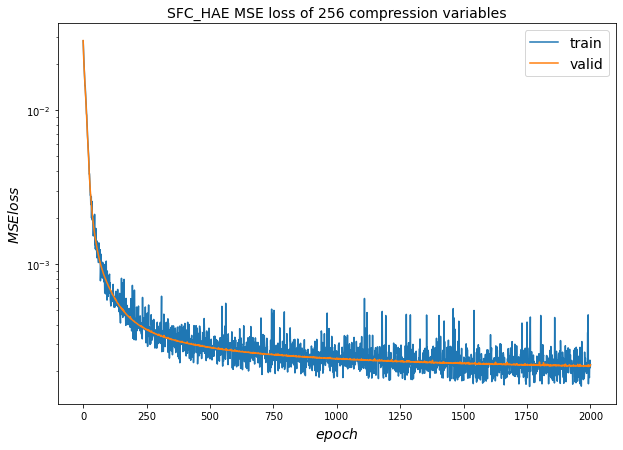

In [26]:
pathName = "./HAE/csv/II_I_Eran2000_LV256_B16_n1600_L0.0001.csv"
name = "SFC_HAE MSE loss of 256 compression variables"
PlotMSELoss(pathName,name)

## Variable 2

### Second network

In [17]:
class CNN_2(nn.Module):
    def __init__(self,hidden_2):
        super(CNN_2, self).__init__()
        self.encoder_h1 = nn.Sequential(
            nn.Tanh(),
            nn.Conv1d(4, 16, 32, 2, 16),
            nn.Tanh(),
            nn.MaxPool1d(3,stride =2),
            nn.Conv1d(16, 16, 32, 2, 16),
            nn.Tanh(),
            nn.MaxPool1d(3,stride =2),
            nn.Conv1d(16, 16, 32, 2, 16),
            nn.Tanh(),
            nn.MaxPool1d(3,stride =2),
            nn.Conv1d(16, 16, 32, 2, 16),
            nn.Tanh(),
            nn.MaxPool1d(3,stride =2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(16*80, hidden_2),
            nn.Tanh(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(2*hidden_2, 16*80),
            nn.Tanh(),
        )
        self.decoder_h1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Tanh(),
            nn.ConvTranspose1d(16, 16, 32, 2, 14), 
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose1d(16, 16, 32, 2, 16), 
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose1d(16, 16, 32, 2, 18), 
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose1d(16, 4, 32, 2, 16), 
            nn.Tanh(),
        )

        # input sparse layers, initialize weight as 0.33, bias as 0
        self.weight1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight1_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight1_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias1 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.weight11 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight11_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight11_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias11 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.weight2 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight2_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight2_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias2 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.weight22 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight22_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight22_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias22 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.weight3 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight3_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight3_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias3 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.zeros(k)),requires_grad = True)
        self.weight33 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight33_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight33_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias33 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.zeros(k)),requires_grad = True)
        self.weight4 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight4_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight4_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias4 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.zeros(k)),requires_grad = True)
        self.weight44 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight44_0 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.weight44_1 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.ones(k)),requires_grad = True)
        self.bias44 = torch.nn.Parameter(torch.FloatTensor(0.33 * torch.zeros(k)),requires_grad = True)
        
        # output sparse layers, initialize weight as 0.083, bias as 0
        self.weight_out1 = torch.nn.Parameter(torch.FloatTensor(0.083 *torch.ones(k)),requires_grad = True) 
        self.weight_out1_0 = torch.nn.Parameter(torch.FloatTensor(0.083* torch.ones(k)),requires_grad = True) 
        self.weight_out1_1 = torch.nn.Parameter(torch.FloatTensor(0.083* torch.ones(k)),requires_grad = True)
        
        self.weight_out11 = torch.nn.Parameter(torch.FloatTensor(0.083 *torch.ones(k)),requires_grad = True) 
        self.weight_out11_0 = torch.nn.Parameter(torch.FloatTensor(0.083* torch.ones(k)),requires_grad = True) 
        self.weight_out11_1 = torch.nn.Parameter(torch.FloatTensor(0.083* torch.ones(k)),requires_grad = True)
        
        self.weight_out2 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        self.weight_out2_0 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        self.weight_out2_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        
        self.weight_out22 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        self.weight_out22_0 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        self.weight_out22_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        
        self.weight_out3 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out3_0 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out3_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        
        self.weight_out33 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out33_0 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out33_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        
        self.weight_out4 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out4_0= torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out4_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        
        self.weight_out44 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out44_0= torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True) 
        self.weight_out44_1 = torch.nn.Parameter(torch.FloatTensor(0.083 * torch.ones(k)),requires_grad = True)
        
        self.bias_out1 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)
        self.bias_out2 = torch.nn.Parameter(torch.FloatTensor(torch.zeros(k)),requires_grad = True)


    def forward(self, x, mode):
        # print("X_size",x.size())
        # first curve
        ToSFC1 = x[:, :, 0] # sfc indices
        ToSFC1Up = torch.zeros_like(ToSFC1)
        ToSFC1Down = torch.zeros_like(ToSFC1)
        ToSFC1Up[:-1] = ToSFC1[1:]
        ToSFC1Up[-1] = ToSFC1[-1]
        ToSFC1Down[1:] = ToSFC1[:-1]
        ToSFC1Down[0] = ToSFC1[0]

        batch_num = ToSFC1.shape[0]
        #print("ToSFC1",ToSFC1.shape) # (16, 20550)
        x1 = x[:, :, 3:5] # u and v
        #print("x1", x1.shape) #        # (16, 20550, 2)
        x1_1d = torch.zeros((batch_num, 4, k)).to(device)
        # first input sparse layer, then transform to sfc order1
        for j in range(batch_num):
            x1_1d[j, 0, :] = x1[j, :, 0][ToSFC1[j].long()] * self.weight1 + \
                             x1[j, :, 0][ToSFC1Up[j].long()] * self.weight1_0 + \
                             x1[j, :, 0][ToSFC1Down[j].long()] * self.weight1_1 + self.bias1
        
            x1_1d[j, 1, :] = x1[j, :, 0][ToSFC1[j].long()] * self.weight11 + \
                             x1[j, :, 0][ToSFC1Up[j].long()] * self.weight11_0 + \
                             x1[j, :, 0][ToSFC1Down[j].long()] * self.weight11_1 + self.bias11

            x1_1d[j, 2, :] = x1[j, :, 1][ToSFC1[j].long()] * self.weight2 + \
                             x1[j, :, 1][ToSFC1Up[j].long()] * self.weight2_0 + \
                             x1[j, :, 1][ToSFC1Down[j].long()] * self.weight2_1 + self.bias2

            x1_1d[j, 3, :] = x1[j, :, 1][ToSFC1[j].long()] * self.weight22 + \
                             x1[j, :, 1][ToSFC1Up[j].long()] * self.weight22_0 + \
                             x1[j, :, 1][ToSFC1Down[j].long()] * self.weight22_1 + self.bias22

        # first cnn encoder
        encoded_1 = self.encoder_h1(x1_1d.view(-1, 4, k)) #(16,4,20550)
        # print("encoded", encoded_1.shape)
        # flatten and concatenate
        encoded_3 = encoded_1.view(-1,16*80)
        # print("Before FC", encoded_3.shape)
        # fully connection
        encoded = self.fc1(encoded_3) # (b,128)
        # print("After encoder FC，the output of encoder",encoded.shape)     
        encoded = torch.cat((encoded, mode),axis = 1)  # Combine the mode_1 to the x1
        
        # print("encoded_combine",encoded.shape)
        decoded_3 = self.decoder_h1(self.fc2(encoded).view(-1, 16, 80))
        # print("The output of decoder: ", decoded_3.shape) # (16, 2, 20550)
        BackSFC1 = torch.argsort(ToSFC1)
        BackSFC1Up = torch.argsort(ToSFC1Up)
        BackSFC1Down = torch.argsort(ToSFC1Down)

        # k = 20550
        # batch_num = ToSFC1.shape[0]
        decoded_sp = torch.zeros((batch_num, k, 2)).to(device)
        # output sparse layer, resort according to sfc transform
        for j in range(batch_num):
            decoded_sp[j, :, 0] = decoded_3[j, 0, :][BackSFC1[j].long()]* self.weight_out1 + \
                                  decoded_3[j, 0, :][BackSFC1Up[j].long()] * self.weight_out1_0 + \
                                  decoded_3[j, 0, :][BackSFC1Down[j].long()] * self.weight_out1_1 + \
                                  decoded_3[j, 1, :][BackSFC1[j].long()]* self.weight_out11 + \
                                  decoded_3[j, 1, :][BackSFC1Up[j].long()] * self.weight_out11_0 + \
                                  decoded_3[j, 1, :][BackSFC1Down[j].long()] * self.weight_out11_1 + self.bias_out1

            decoded_sp[j, :, 1] = decoded_3[j, 2, :][BackSFC1[j].long()] * self.weight_out3 + \
                                  decoded_3[j, 2, :][BackSFC1Up[j].long()] * self.weight_out3_0 + \
                                  decoded_3[j, 2, :][BackSFC1Down[j].long()] * self.weight_out3_1 + \
                                  decoded_3[j, 3, :][BackSFC1[j].long()] * self.weight_out33 + \
                                  decoded_3[j, 3, :][BackSFC1Up[j].long()] * self.weight_out33_0 + \
                                  decoded_3[j, 3, :][BackSFC1Down[j].long()] * self.weight_out33_1 + self.bias_out2       
        # resort 1D to 2D
        decoded = F.tanh(decoded_sp) # both are BATCH_SIZE by nNodes by 2
        return encoded, decoded

### Save and Get mode

In [18]:
# SFC-CAE: one curve with nearest neighbour smoothing and compressing to 1 latent variables
print("compress to 1")
Latent_num = 1
torch.manual_seed(42)
# Hyper-parameters
EPOCH = 3001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_data.shape) # nTrain by number of nodes by 5

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = training_data, batch_size = BATCH_SIZE, shuffle = True)

compress to 1
(1600, 20550, 5)


In [ ]:
# autoencoder = torch.load("./SFC_CAE/pkl/II_Eran3000_LV1_B16_n1600_L0.0001.pkl")

In [ ]:
# # pass training, validation and test data through the autoencoder
# t_predict_0 = time.time()

# mode_1train, training_decoded = autoencoder.to(device)(torch.tensor(training_data).to(device))
# train_error_autoencoder = (training_decoded.cpu().detach().numpy() - training_data[:,:,3:5])
# print("MSE_err of training data", (train_error_autoencoder**2).mean())

# mode_1valid, valid_decoded = autoencoder.to(device)(torch.tensor(valid_data).to(device))
# valid_error_autoencoder = (valid_decoded.cpu().detach().numpy() - valid_data[:, :, 3:5])
# print("Mse_err of validation data", (valid_error_autoencoder**2).mean())

# mode_1test, test_decoded = autoencoder.to(device)(torch.tensor(test_data).to(device))
# test_error_autoencoder = (test_decoded.cpu().detach().numpy() - test_data[:, :, 3:5])
# print("Mse_err of test data", (test_error_autoencoder**2).mean())
# t_predict_1 = time.time()


# # total_decoded = getTotal_decoded(training_decoded,valid_decoded,test_decoded,train_index,valid_index,test_index)
# # total_error_autoencoder = (total_decoded - total_data[:, :, 3:5])
# # print("Mse_err of total data", (total_error_autoencoder**2).mean())

# print(mode_1train.shape)
# print(mode_1valid.shape)
# print(mode_1test.shape)
# print("Rec:",t_predict_1-t_predict_0)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE_err of training data 0.0025713314478904483
Mse_err of validation data 0.0032628900887184367
Mse_err of test data 0.002767284384906429
torch.Size([1600, 1])
torch.Size([200, 1])
torch.Size([200, 1])
Rec: 6.08609938621521


In [19]:
# Because we have saved the mode at SFC-CAE, we can directly load them
Latent_num = 1
torch.manual_seed(42)
BATCH_SIZE = 16
LR = 0.0001
nTrain = 1600

path_train = "./HAE/mode_new/II_mode1_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_train.csv"
path_valid = "./HAE/mode_new/II_mode1_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_valid.csv"
path_test = "./HAE/mode_new/II_mode1_LV"+str(Latent_num)+"_Eran"+str(3000) + "_B"+str(BATCH_SIZE)+"_n"+ str(nTrain)+"_L"+str(LR)+"_test.csv"
print(path_train)
# saveMode(path_train,path_valid,path_test,mode_1train,mode_1valid,mode_1test)

./HAE/mode_new/II_mode1_LV1_Eran3000_B16_n1600_L0.0001_train.csv


In [20]:
mode_1train,mode_1valid,mode_1test = getMode(path_train,path_valid,path_test)
mode_1train = torch.from_numpy(mode_1train.reshape(-1,1)).to(device)
mode_1valid = torch.from_numpy(mode_1valid.reshape(-1,1)).to(device)
mode_1test = torch.from_numpy(mode_1test.reshape(-1,1)).to(device)
print(mode_1train.shape)
print(mode_1test.shape)
print(mode_1valid.shape)

torch.Size([1600, 1])
torch.Size([200, 1])
torch.Size([200, 1])


### Load model and calculate MSE

In [21]:
# SFC-HAE: one curve with nearest neighbour smoothing and compressing to 2 latent variables
print("compress to 2")
torch.manual_seed(42)
# Hyper-parameters
Latent_num = 2
EPOCH = 3001
BATCH_SIZE = 16
LR = 0.0001
k = nNodes # number of nodes - this has to match training_data.shape[0]
print(training_data.shape) # nTrain by number of nodes by 5

# Combing the input data and the mode
train_set = TensorDataset(torch.from_numpy(training_data), mode_1train)

# Data Loader for easy mini-batch return in training
train_loader = Data.DataLoader(dataset = train_set, batch_size =BATCH_SIZE , shuffle = True)

compress to 2
(1600, 20550, 5)


In [22]:
autoencoder_2 = torch.load("./HAE/pkl/II_I_Eran3000_LV2_B16_n1600_L0.0001.pkl")

In [23]:
# pass training, validation and test data through the autoencoder
t_predict_0 = time.time()
mode_2train, training_decoded_2 = autoencoder_2.to(device)(torch.tensor(training_data).to(device),mode_1train.float().to(device))
t_predict_1 = time.time()
train_error_autoencoder2 = (training_decoded_2.cpu().detach().numpy() - training_data[:,:,3:5])
print("MSE_err of training data", (train_error_autoencoder2**2).mean())

t_predict_2 = time.time()
mode_2valid, valid_decoded_2 = autoencoder_2.to(device)(torch.tensor(valid_data).to(device),mode_1valid.float().to(device))
t_predict_3 = time.time()
valid_error_autoencoder2 = (valid_decoded_2.cpu().detach().numpy() - valid_data[:, :, 3:5])
print("Mse_err of validation data", (valid_error_autoencoder2**2).mean())

t_predict_4 = time.time()
mode_2test, test_decoded_2 = autoencoder_2.to(device)(torch.tensor(test_data).to(device),mode_1test.float().to(device))
t_predict_5 = time.time()
test_error_autoencoder2 = (test_decoded_2.cpu().detach().numpy() - test_data[:, :, 3:5])
print("Mse_err of test data", (test_error_autoencoder2**2).mean())

# total_decoded2 = getTotal_decoded(training_decoded_2,valid_decoded_2,test_decoded_2,train_index,valid_index,test_index)
# total_error_autoencoder2 = (total_decoded2 - total_data[:, :, 3:5])
# print("Mse_err of total data", (total_error_autoencoder2**2).mean())

print(mode_2train.shape)
print(mode_2valid.shape)
print(mode_2test.shape)
print("Reconstruction time: ", t_predict_1 - t_predict_0+t_predict_3 - t_predict_2+t_predict_5 - t_predict_4)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE_err of training data 0.0018782681396579712
Mse_err of validation data 0.0018474784515350741
Mse_err of test data 0.0017679818988714344
torch.Size([1600, 2])
torch.Size([200, 2])
torch.Size([200, 2])
Reconstruction time:  5.560319900512695


### Plot loss

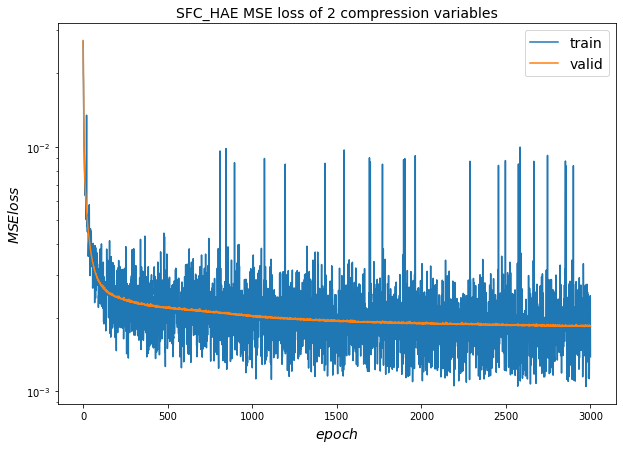

In [24]:
pathName = "./HAE/csv/II_I_Eran3000_LV2_B16_n1600_L0.0001.csv"
name = "SFC_HAE MSE loss of 2 compression variables"
PlotMSELoss(pathName,name)